# Agentic RAG

https://docs.langchain.com/oss/python/langgraph/agentic-rag

![](https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/langgraph-hybrid-rag-tutorial.png?w=1100&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=2425baddda7209901bdde4425c23292c)

In [1]:
%pip install -Uq langchain langchain-openai langchain-community langchain-text-splitters langgraph

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 0.3.1 requires langchain-core<1.0.0,>=0.3.70, but you have langchain-core 1.2.11 which is incompatible.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")

## 1.Indexing
외부문서를 임베딩을 거쳐 벡터스토어에 저장

In [3]:
# 문서 전처리
from langchain_community.document_loaders import WebBaseLoader  # 웹페이지 로더

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = []
for url in urls:
    loader = WebBaseLoader(url)  # 해당 URL용 로더 생성
    doc = loader.load() # 웹페이지 하나가 하나의 Document 변환
    docs.append(doc)

print(len(docs))

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


3


In [11]:
# [[Document], [Document], [Document]]
docs[0][0].page_content[:100]  # 첫 번째 문서의 첫 Document에서 본문 앞 100글자 슬라이싱

"\n\n\n\n\n\nReward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil"

In [12]:
# chunking작업
from langchain_text_splitters import RecursiveCharacterTextSplitter  # 문서 분할기

docs_list = [item for sublist in docs for item in sublist]  # 중첩 리스트([[Doc], ...])를 1차원 리스트로 변환

# tiktoken_encoder: 토큰수 기준으로 분할(기존 객체는 글자수 기반으로 처리)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(  # 토큰 기준 청킹용 분할기 생성
    chunk_size=100,    # 청크 최대 토큰 크기
    chunk_overlap=50   # 이전 청크와 겹침 토큰 크기
)
docs_splits = text_splitter.split_documents(docs_list)  # Document 리스트를 청크 Document로 변환
print(len(docs_splits))  # 생성된 청크 개수

538


In [13]:
# 테스트용 InMemoryVectorStore
from langchain_core.vectorstores import InMemoryVectorStore  # 메모리 기반(휘발성) 벡터스토어
from langchain_openai import OpenAIEmbeddings  # OpenAI 임베딩 모델 래퍼 클래스

vectorstore = InMemoryVectorStore.from_documents(  # 청크 문서를 임베딩해서 벡터스토어 생성
    docs_splits,  # 청킹된 리스트
    embedding=OpenAIEmbeddings(model='text-embedding-3-small')  # 임베딩 모델
)
retriever = vectorstore.as_retriever()  # 벡터스토어를 Retriever 형태로 변환 (검색기)
retriever.invoke('types of reward hacking')  # 질문과 가장 가까운 청크 검색

[Document(id='e62e228a-98f5-4b4c-ad50-6f6032b9b2e2', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for re

In [14]:
# retriever tool 생성
from langchain_core.tools import tool  # 함수를 Langchain Tool로 등록하는 데코레이터

# Retriever로 블로그 청크를 검색해서 본문을 합쳐 반환하는 도구 함수
@tool
def retrieve_blog_posts(query: str) -> str:
    """Lilian Weng의 블로그 글을 검색하고 정보를 획득하는 도구"""
    docs = retriever.invoke(query)
    return '\n\n'.join([doc.page_content for doc in docs])

retrieve_blog_posts.invoke('types of reward hacking')  # Tool 형태로 호출

'Why does Reward Hacking Exist?#\n\nDetecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.'

## 2.Retrieval & Generation
사용자에 요청에 필요한 외부문서를 검색하고, 이를 기반으로 응답


### Generate Query Agent

In [15]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model('openai:gpt-4.1-mini', temperature=0)  # 응답용 LLM (완전 결정적 출력)
response_model_with_tools = response_model.bind_tools([retrieve_blog_posts])  # LLM에 Tool 바인딩

# 메시지 상태를 받아서 도구 호출 또는 바로 응답을 생성하는 함수
def generate_query_or_respond(state: MessagesState):
    response = response_model_with_tools.invoke(state['messages'])  # 현재 대화(messages)로 LLM 호출(필요시 tool_call)
    return {'messages': [response]}  # LangGraph 상태 저장에 맞춰 반환

In [16]:
# generate_query 경우
state = {'messages': [('human', 'Lilian Weng이 말한 환각이란')]}
response = generate_query_or_respond(state)
response['messages'][-1].pretty_print()  # 마지막 메시지(모델 응답 or tool_call)을 보기 좋게 출력

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_IBbHQGnYQbhOx1gPukJv3JiS)
 Call ID: call_IBbHQGnYQbhOx1gPukJv3JiS
  Args:
    query: Lilian Weng 환각


In [18]:
# respond 경우 (일반 대화 질문으로 바로 응답)
state = {'messages': [('human', '전기 먹었니?')]}
response = generate_query_or_respond(state)
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

"전기 먹었니?"라는 표현이 상황에 따라 다르게 해석될 수 있는데요, 보통은 전기를 많이 사용했는지, 혹은 전기 요금이 많이 나왔는지 묻는 말일 수 있습니다. 어떤 의미로 물어보신 건가요? 좀 더 구체적으로 알려주시면 도움이 될 것 같아요!


### Grade Document Agent (conditional edge function)
조회된 문서를 평가해서 사용자의 질문과 적합한지를 판단.
- generate_answer: `yes`
- rewrite_query: `no`

In [20]:
from pydantic import BaseModel, Field  # 구조화 출력 스키마 정의용
from typing import Literal             # 라우팅 반환값을 리터럴로 제한
from langchain_core.prompts import PromptTemplate  # 프롬프트 템플릿 유틸리티

GRADE_PROMPT = (
    "귀하는 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n "
    "검색된 문서는 다음과 같습니다: \n\n {context} \n\n "
    "사용자 질문은 다음과 같습니다: {question} \n "
    "문서에 사용자 질문과 관련된 키워드 또는 의미론적 의미가 포함되어 있으면 관련성 있음으로 평가하세요. \n "
    "문서가 질문과 관련이 있는지 여부를 나타내는 이진 점수('yes' 또는 'no')를 부여하세요."
)

# 평가 결과를 구조화해서 받기 위한 스키마
class GradeDocuments(BaseModel):
    binary_score: str = Field(description='관련있으면 "yes"를, 관련이 없으면 "no"를 작성하세요.')


grader_model = init_chat_model('openai:gpt-4.1')

# 검색 결과(context)가 질문과 관련 있는지 판정 후 다음 노드로 라우팅하는 함수
def grade_documents(state: MessagesState) -> Literal['generate_answer', 'rewrite_query']:
    # 사용자의 질문
    question = state['messages'][0].content  # 최초 human 메시지
    # 벡터스토어 조회결과
    context = state['messages'][-1].content  # 마지막 메시지(검색 결과/컨텍스트)

    prompt = PromptTemplate.from_template(GRADE_PROMPT)  # 템플릿을 Prompt 객체로 변환
    chain = prompt | grader_model.with_structured_output(GradeDocuments)  # LLM 출력 JSON -> GradeDocuments 파싱해서 반환
    response = chain.invoke({'question': question, 'context': context})   # 관련 여부 체크

    score = response.binary_score  # 구조화 출력에서 yes/no를 추출
    if score == 'yes':
        return 'generate_answer' # 다음 노드(에이젼트 이름)
    else:
        return 'rewrite_query'

In [ ]:
# generate_answer 경우
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

messages = [
    HumanMessage(content='What does Lilien Weng says about reward hacking?'),
    AIMessage(     # 모델이 Tool 호출을 하도록 만든 메시지
        content='',
        tool_calls=[
            {
                'id': "1",                           # Tool Call 식별자
                'name': 'retrieve_blog_posts',       # 호출할 Tool 이름
                'args': {'query': 'reward hacking'}  # Tool 입력값
            }
        ]
    ),
    ToolMessage(  # Tool 실행 결과
        tool_call_id="1",
        content='''
Why does Reward Hacking Exist?#

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.
'''
    )
]

grade_documents({'messages': messages})  # 관련성 체크 후 결과(generate_answer or rewrite_query)


'generate_answer'

In [25]:
# rewrite_query 경우
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

messages = [
    HumanMessage(content='What does Lilien Weng says about reward hacking?'),
    AIMessage(
        content='',
        tool_calls=[
            {
                'id': "1",
                'name': 'retrieve_blog_posts',
                'args': {'query': 'reward hacking'}
            }
        ]
    ),
    ToolMessage(
        tool_call_id="1",
        content='''Lilien Weng아 같이 해킹이나 해보자.'''
    )
]

grade_documents({'messages': messages})

'rewrite_query'

### Rewrite Query Agent

In [27]:
REWRITE_PROMPT = (
    "입력된 내용을 바탕으로 사용자의 근본적인 의도와 의미를 분석한다. \n "
    "다음은 초기 질문이다:"
    " \n  -------  \n "
    " {question} "
    " \n  -------  \n "
    "분석한 의도를 반영하여 더 명확하고 구체적인 질문으로 재구성한다:"
)

# 사용자의 원래 질문을 더 구체적으로 바꿔서 반환하는 노드 함수
def rewrite_query(state: MessagesState):
    messages = state['messages']  # 현재 상태의 메시지 목록
    question = messages[0].content # 사용자의 원래 질문
    chain = PromptTemplate.from_template(REWRITE_PROMPT) | response_model  # 체인 구성
    response = chain.invoke({'question': question})  # 모델 응답 생성
    return {'messages': [response]}  # LangGraph 상태 업데이트 형태

In [28]:
# rewrite_query 경우
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

messages = [
    HumanMessage(content='What does Lilien Weng says about reward hacking?'),
    AIMessage(
        content='',
        tool_calls=[
            {
                'id': "1",
                'name': 'retrieve_blog_posts',
                'args': {'query': 'reward hacking'}
            }
        ]
    ),
    ToolMessage(
        tool_call_id="1",
        content='''meow'''  # 질문과 무관한 컨텍스트
    )
]

response = rewrite_query({'messages': messages})  # 쿼리 정확하게 재작성
print(response['messages'][-1].content)

Lilien Weng이 보상 해킹(reward hacking)에 대해 어떤 견해를 가지고 있으며, 그 문제의 원인과 해결 방안에 대해 어떻게 설명하는지 구체적으로 알려줄 수 있나요?


### Generate Answer Agent

In [29]:
GENERATE_PROMPT = (
    "귀하는 질문-답변 작업을 위한 도우미입니다. "
    "제공된 검색된 컨텍스트 조각을 사용하여 질문에 답변하세요. "
    "답변을 모르면 모른다고 말하세요. "
    "최대 세 문장을 사용하고 답변을 간결하게 유지하세요. \n "
    "(한국어로 답변해주세요) \n "
    "질문:  {question}   \n "
    "컨텍스트:  {context} "
)

def generate_answer(state: MessagesState):
    question = state['messages'][0].content # 사용자 원래 질문
    context = state['messages'][-1].content # retriever 도구메세지 내용

    chain = PromptTemplate.from_template(GENERATE_PROMPT) | response_model
    response = chain.invoke({'question': question, 'context': context})
    return {'messages': [response]}

In [30]:
# generate_answer 경우
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

messages = [
    HumanMessage(content='What does Lilien Weng says about reward hacking?'),
    AIMessage(
        content='',
        tool_calls=[
            {
                'id': "1",
                'name': 'retrieve_blog_posts',
                'args': {'query': 'reward hacking'}
            }
        ]
    ),
    ToolMessage(
        tool_call_id="1",
        content='''
Why does Reward Hacking Exist?#

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.
'''
    )
]

response = generate_answer({'messages': messages})
print(response['messages'][-1].content)

Lilien Weng은 보상 해킹을 환경 또는 목표의 잘못된 명세와 보상 조작 두 가지 유형으로 분류합니다. 보상 해킹은 넓은 개념으로, 보상 조작과는 구별되지만 관련된 행동으로 봅니다.


### 그래프 생성

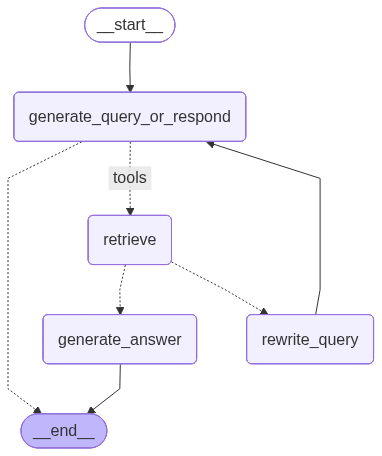

In [31]:
from langgraph.graph import StateGraph, START, END        # 그래프 정의 / 시작노드 / 종료 노드
from langgraph.prebuilt import ToolNode, tools_condition  # Tool 실행 노드 / tool 호출 분기

workflow = StateGraph(MessagesState)  # 메시지 상태로 관리하는 그래프 생성

workflow.add_node(generate_query_or_respond)  # tool 호출 여부 확인 노드
workflow.add_node("retrieve", ToolNode([retrieve_blog_posts]))  # 툴 실행 노드 (검색 기능)
workflow.add_node(rewrite_query)    # 질문 재작성 노드
workflow.add_node(generate_answer)  # 최종 답변 생성 노드

workflow.add_edge(START, 'generate_query_or_respond')
workflow.add_conditional_edges(  # tool 호출을 할지
    'generate_query_or_respond',
    tools_condition,
    {
        'tools': 'retrieve',
        END: END # __end__
    }
)
workflow.add_conditional_edges(  # 검색 결과 연관성 여부에 따라
    'retrieve',
    grade_documents, # yes/no -> generate_answer/rewrite_query
)
workflow.add_edge('generate_answer', END)  # yes는 최종답변 생성
workflow.add_edge('rewrite_query', 'generate_query_or_respond')  # no는 재작성 ~ LLM 노드

graph = workflow.compile()  # 정의한 워크플로우를 실행 가능한 그래프로 컴파일
graph

## 실행

In [32]:
# 그래프를 스트리밍 모드로 실행
for chunk in graph.stream({'messages': [('human', 'Lilian Weng은 보상해킹을 어떻게 정의하는가?')]}):

    for node_name, update in chunk.items():  # 이번 스텝에서의 노드들의 출력 순회
        print(f'Update from Node [{node_name}]:')  # 어떤 노드에서 업데이트 되었는지
        update['messages'][-1].pretty_print()  # 해당 노드의 마지막 메시지
        print()

Update from Node [generate_query_or_respond]:
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_RUbEWksnafh6rnjvCwSThUnN)
 Call ID: call_RUbEWksnafh6rnjvCwSThUnN
  Args:
    query: reward hacking

Update from Node [retrieve]:
================================= Tool Message =================================
Name: retrieve_blog_posts

Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.

Why does Reward Hacking Exist?#

In-Context Reward Hacking#

Detecting Reward Hacking#

Update from Node [generate_answer]:
================================== Ai Message ==================================

Lilian Weng은 보상해킹을 강화학습 에이전트가 보상 함수의 결함이나 모

In [34]:
for chunk in graph.stream({'messages': [('human', '진격거 리바이의 계급은?')]}):

    for node_name, update in chunk.items():
        print(f'Update from Node [{node_name}]:')
        update['messages'][-1].pretty_print()
        print()

Update from Node [generate_query_or_respond]:
================================== Ai Message ==================================

진격의 거인(Attack on Titan)에서 리바이(Levi)의 계급은 '대위(Captain)'입니다. 그는 조사병단의 대위로서 매우 뛰어난 전투 능력과 리더십을 가진 인물입니다.



In [37]:
from pprint import pprint

response = graph.invoke({'messages': [('human', '진격거 리바이의 계급은?')]})
pprint(response['messages'])

[HumanMessage(content='진격거 리바이의 계급은?', additional_kwargs={}, response_metadata={}, id='b9fdacf9-43b4-421b-9fba-de721a2797e6'),
 AIMessage(content="진격의 거인(Attack on Titan)에서 리바이(Levi)의 계급은 '대위(Captain)'입니다. 그는 조사병단의 대위로서 매우 뛰어난 전투 능력과 리더십을 가진 인물입니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 68, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D8LFybm5ghM03iryUqVfRszmluohC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c50b7-283a-7381-8e21-b04949678eb2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 68, 'output_tokens': 57, 'total_tokens': 125, 'input_t

In [38]:
for chunk in graph.stream({'messages': [('human', 'Lilian Weng이 좋아한 진격거 캐릭터는?')]}):

    for node_name, update in chunk.items():
        print(f'Update from Node [{node_name}]:')
        update['messages'][-1].pretty_print()
        print()

Update from Node [generate_query_or_respond]:
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_hiYewB9WJj7G3ohubF2UMnm7)
 Call ID: call_hiYewB9WJj7G3ohubF2UMnm7
  Args:
    query: Lilian Weng 진격거 캐릭터

Update from Node [retrieve]:
================================= Tool Message =================================
Name: retrieve_blog_posts

Weng, Lilian. (Jul 2024). Extrinsic Hallucinations in LLMs. Lil’Log. https://lilianweng.github.io/posts/2024-07-07-hallucination/.

Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      Extrinsic Hallucinations in LLMs
    
Date: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng

author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Apr",
  url     = "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
}
References#

author  = "Weng, Lilian",
  journal = "lilianweng.gith